# Study Case A
This notebook will showcase an overview of the Devices and Samples models, displaying statistical summaries and distribuitions for each model. Afterwards, we will add new features in attempt to answer the proposed questions.

## Questions and problem definition
**WIP** Define the problem and its questions

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)


# helper functions
def load_df(path, columns=None, nthreads=4, strings_to_categorical=True):
    try:
        table = pq.read_table(path, columns=columns, nthreads=nthreads)
        return table.to_pandas(strings_to_categorical=strings_to_categorical)
    except Exception as e:
        print(e)

def prepare_devices(path):
    cols = ['id', 'model', 'brand', 'manufacturer', 'product', 'os_version', 'kernel_version', 'is_root']
    return load_df(path, cols)
        
def prepare_samples(path):
    cols = ['device_id', 'timestamp', 'battery_level', 'network_status', 'screen_on', 
            'bluetooth_enabled', 'location_enabled', 'power_saver_enabled', 'nfc_enabled',
            'unknown_sources', 'developer_mode']
    
    # sorted by [device_id, timestamp]
    df = load_df(path, cols)

    df = df.reset_index(drop=True)

    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')

    df[converted_int.columns] = converted_int
    
    return df

## Acquire data
After importing the necessary libraries, we load the files into dataframes. The *samples* data was sorted beforehand by *device_id* and *timestamp*.

In [2]:
devices = prepare_devices('../src/devices.parquet')
samples = prepare_samples('../src/samples.parquet')

## Analyze by describing data
To better understand the data, we will start by looking at a sample of the data.

In [3]:
devices.sample(5)

,id,model,brand,manufacturer,product,os_version,kernel_version,is_root
687,688,sm-e500m,samsung,samsung,e5lteub,5.1.1,3.10.49-7815827,0
669,670,a0001,oneplus,oneplus,bacon,6.0.1,3.4.110-cyanogenmod-g326cf3a,0
1235,1236,asus_z012d,asus,asus,ww_phone,7.0,3.18.31-perf-g4dbe070-00013-gfcbc3b3,0
2315,2316,be_pure,ulefone,alps,be_pure,4.4.2,3.4.67,1
3162,3163,sm-j730f,samsung,samsung,j7y17ltexx,7.0,3.18.14-12784722,0


In [4]:
samples.sample(5)

,device_id,timestamp,battery_level,network_status,screen_on,bluetooth_enabled,location_enabled,power_saver_enabled,nfc_enabled,unknown_sources,developer_mode
1135956,745,2017-12-15 23:38:48,36,disconnected,0,0,1,0,0,1,0
4080032,2712,2017-11-26 04:24:45,89,disconnected,0,1,1,0,0,0,0
2120077,1455,2017-10-31 15:31:19,56,hspap,0,0,0,0,0,0,0
514369,288,2018-02-08 20:16:36,31,wifi,0,0,1,0,0,0,0
2181267,1468,2018-04-16 14:23:36,47,wifi,0,0,0,0,0,1,0


### What are the data types for the various features?
#### Devices
- Six features are categories which represent device's specs.
- *is_root* is a boolean variable that indicates whether the device has root access.

#### Samples
- The last seven features are booleans, these are each device's settings.
- The remaining features will be useful to group the data into different subsets.

In [5]:
devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 8 columns):
id                3265 non-null uint16
model             3265 non-null category
brand             3265 non-null category
manufacturer      3265 non-null category
product           3265 non-null category
os_version        3265 non-null category
kernel_version    3265 non-null category
is_root           3265 non-null uint8
dtypes: category(6), uint16(1), uint8(1)
memory usage: 193.3 KB


In [6]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4587326 entries, 0 to 4587325
Data columns (total 11 columns):
device_id              uint16
timestamp              datetime64[ns]
battery_level          uint8
network_status         category
screen_on              uint8
bluetooth_enabled      uint8
location_enabled       uint8
power_saver_enabled    uint8
nfc_enabled            uint8
unknown_sources        uint8
developer_mode         uint8
dtypes: category(1), datetime64[ns](1), uint16(1), uint8(8)
memory usage: 83.1 MB


### What is the distribution of categorical features?

In [7]:
devices.describe(include=['category'])

,model,brand,manufacturer,product,os_version,kernel_version
count,3265,3265,3265,3265,3265,3265
unique,798,124,131,812,22,816
top,ale-l21,samsung,samsung,ale-l21,7.0,3.18.14-11104523
freq,165,1011,1006,165,1007,103


In [8]:
samples.describe(include=['category'])

,network_status
count,4587326
unique,20
top,wifi
freq,2458197


#### Inspecting *network_status* in greater detail
- We can verify that one of the most top values has label `0` which does not provide a meaningful value!

In [9]:
samples.network_status.value_counts()

wifi             2458197
disconnected     1360836
lte               433236
hspap             133264
utms               79950
0                  41508
hspa               36341
edge               22118
disconnecting      12470
hsupa               4228
hsdpa               3377
gprs                1421
connecting            99
19                    78
20                    71
evdo_a                47
30                    37
1xrtt                 30
16                    17
18                     1
Name: network_status, dtype: int64

### How many devices have samples?
Lets check what is the percentage of devices that uploaded **at least one sample**.

Defining the conversion goal, as the number of resgistered devices that upload samples, we can observe that:

The conversion is slightly below 50%, the conversion rate is not very high!

In [10]:
percentage = round(100 * samples.device_id.nunique() / devices.shape[0], 1)
print('From a population of {0} devices, {1} ' \
      'devices have samples, which represents {2}%'.format(devices.shape[0], samples.device_id.nunique(), percentage))

From a population of 3265 devices, 1597 devices have samples, which represents 48.9%


#### Additionally, we can calculate a few more conversion rates:

In [11]:
def calculate_conversion(limit):
    df = pd.DataFrame(samples.groupby('device_id').size() > limit, columns=['goal'])
    num = df[df.goal].shape[0]
    percentage = round(100 * num / devices.shape[0], 1)
    print('{0} devices have more than {1} samples, that represents {2}%'.format(num, limit, percentage))

calculate_conversion(100)
calculate_conversion(1000)

1137 devices have more than 100 samples, that represents 34.8%
693 devices have more than 1000 samples, that represents 21.2%


## Visualizing data
Visualizing data is crucial for recognizing underlying patterns to exploit in the model.

[Text(0,0.5,'# Devices')]

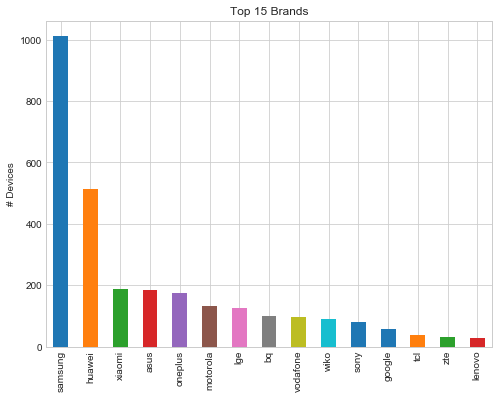

In [12]:
brands = devices.brand.value_counts()[0:15]
cx = brands.plot(kind='bar', title='Top 15 Brands', figsize=figsize)
cx.set(ylabel='# Devices')

[Text(0,0.5,'# Devices')]

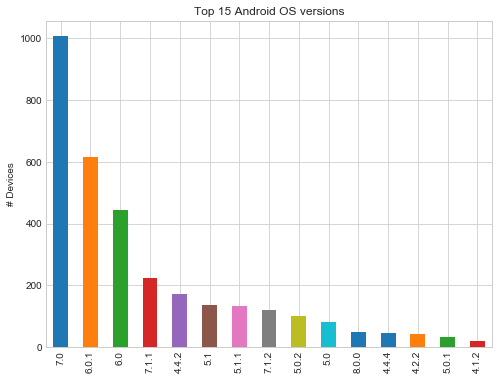

In [13]:
versions = devices.os_version.value_counts()[:15]
pl = versions.plot(kind='bar', title='Top 15 Android OS versions', figsize=figsize)
pl.set(ylabel='# Devices')

[Text(0,0.5,'# Samples')]

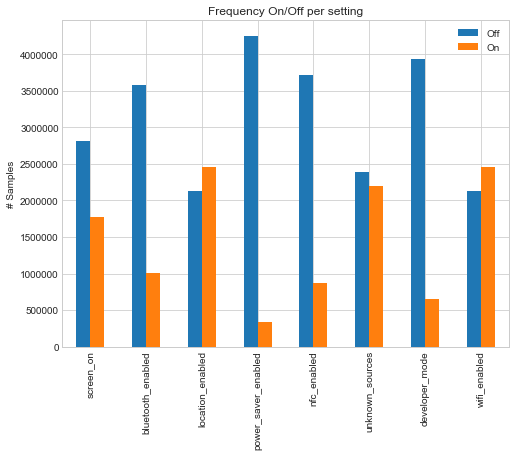

In [14]:
settings = ['screen_on', 'bluetooth_enabled', 'location_enabled', 'power_saver_enabled', 
            'nfc_enabled', 'unknown_sources', 'developer_mode', 'wifi_enabled']

# Add new setting
samples['wifi_enabled'] = (samples['network_status'] == 'wifi').astype(np.uint8)

# Frequency on/off per setting
freqs = samples[settings].apply(pd.value_counts, axis=0).T
freqs.columns = ['Off', 'On']
pl = freqs.plot(kind='bar', title='Frequency On/Off per setting', figsize=figsize)
pl.set(ylabel='# Samples')

## Transforming Features
1. First, add a new feature *wifi_enabled* (done in the previous step), will tell us if a sample has `wifi` value or some other status. This will be necessary to calculate another feature.
2. Next, calculate the changes over time and battery level, *time_diff* will be the total seconds passed between each sample and *pct_change* the change percentage compared with the previous sample. The latter can be specially useful to group samples in batches of battery levels.
3. We will also add an extra feature *discharging* (`1.0` for discharge state, `0.0` for charge state) which will make it easier to group samples by battery state.
4. Combine the settings values into a numberic class, obtained by converting the group of values into a decimal number.
5. Lastly, drop useless features. We can drop the settings features since we have the *combination* value.

In [15]:
samples['time_diff'] = samples['timestamp'].diff().dt.total_seconds()
samples.loc[samples.device_id != samples.device_id.shift(), 'time_diff'] = None

samples['change'] = samples['battery_level'].pct_change().round(2)
samples.loc[samples.device_id != samples.device_id.shift(), 'change'] = None

samples['discharging'] = samples.battery_level.shift() >= samples.battery_level
samples.loc[samples.device_id != samples.device_id.shift(), 'discharging'] = None

samples['combination'] = np.packbits(samples[settings].values, axis=-1)

samples = samples.drop(settings, axis=1)

samples.sample(5)

,device_id,timestamp,battery_level,network_status,time_diff,change,discharging,combination
3249363,2234,2018-01-11 01:23:18,91,wifi,174.0,0.01,0.0,39
3342401,2298,2017-12-24 12:37:14,42,disconnected,40.0,0.02,0.0,6
1862561,1267,2017-11-23 18:36:23,69,wifi,70.0,0.01,0.0,1
4112536,2725,2018-01-14 20:11:53,73,wifi,30.0,-0.01,1.0,131
339270,219,2018-02-09 20:06:15,73,disconnected,120.0,-0.01,1.0,208


[Text(0,0.5,'# Samples'), Text(0.5,0,'Combinations')]

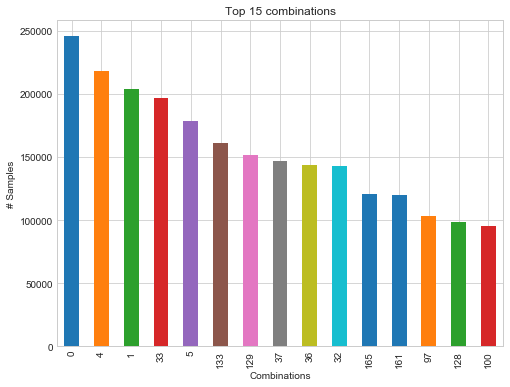

In [16]:
combs = samples.combination.value_counts()[0:15].T
pl = combs.plot(kind='bar', title='Top 15 combinations', figsize=figsize)
pl.set(xlabel='Combinations', ylabel='# Samples')